# Classification on a given dataset

We first import the necessary libraries for the exercice and load the data from the given files

In [101]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

def load_data():
    path = "data/classification/"
    X_train = np.load(path + "X_train.npy")
    y_train = np.load(path + "y_train.npy")
    X_test = np.load(path + "X_test.npy")
    y_test = np.load(path + "y_test.npy")
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()

# Data analysis

Before trying anything on the classification. We analyse the train data, see the different classes and the repartition of the different classes

X_train shape: (2000, 30)
y_train shape: (2000,)
Missing values in X_train: 0
Missing values in X_test: 0
Feature means (train): [ 0.00278456  0.0258194  -0.02816605 -0.02500212  0.00163257]
Feature stds (train): [0.97941116 0.98730757 0.97436539 0.96622428 2.54260032]
Class distribution: {0: 1019, 1: 981}


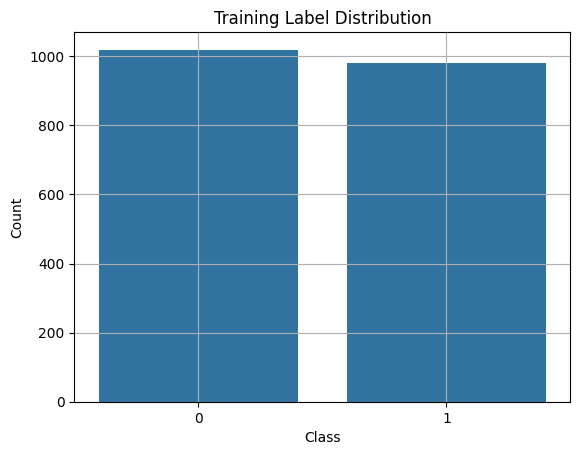

In [102]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())

print("Feature means (train):", np.mean(X_train, axis=0)[:5])
print("Feature stds (train):", np.std(X_train, axis=0)[:5])

unique_classes, counts = np.unique(y_train, return_counts=True)
print("Class distribution:", dict(zip(unique_classes, counts)))

sns.countplot(x=y_train)
plt.title("Training Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(True)
plt.show()


## 📊 Dataset Analysis

- The dataset contains **2000 training samples** with **30 features**.
- The **target variable** is **binary** and **evenly balanced** between class 0 and class 1.
- There are **no missing values** in either the training or test sets.
- Feature values are already **approximately standardized**:
  - Means are close to 0
  - Most standard deviations are close to 1, with one slightly higher (~2.5)
- Moderate dimensionality (p < n)


# Data preprocessing

We will use a scaller on a separate value to test its influence on scores

In [103]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {}

# Logistic Regression

We will use the linear regression as a base score to compare other models.

In [104]:
def logistic_Regression(X_train, X_test, y_train, y_test):
    linreg = LogisticRegression()
    linreg.fit(X_train, y_train)
    
    y_pred_linreg = linreg.predict(X_test)
    y_pred_class = (y_pred_linreg >= 0.5).astype(int)
    
    accuracy_linreg = accuracy_score(y_test, y_pred_class)
    print(f"Linear Regression Test Accuracy (rounded prediction): {accuracy_linreg:.4f}")
    return accuracy_linreg

linear_acc =  logistic_Regression(X_train, X_test, y_train, y_test)
linear_acc_scaled =  logistic_Regression(X_train_scaled, X_test_scaled, y_train, y_test)


Linear Regression Test Accuracy (rounded prediction): 0.7435
Linear Regression Test Accuracy (rounded prediction): 0.7440


# Support Vector Classifier (SVC)

The goal of SVC is to determine a frontier between the 0 and 1 classes.  
In this algorithm, we have to be careful, as Maximum Margin Classifiers are very sensitive to outliers.  
We therefore need a threshold (`C` parameter) that allows misclassifications when necessary to improve generalization.

We will try three different approaches to draw that decision boundary:

- **Linear kernel**: builds a straight line as the frontier between classes.
- **RBF kernel**: draws a Gaussian-shaped curve to separate the data.
- **Polynomial kernel**: builds a polynomial curve to adapt to more complex patterns.


To maximize the model’s accuracy, we will tune important **hyperparameters** (`C`, `degree`, `gamma`, `coef0`) for each kernel.  
Here, `degree` controls the complexity of the polynomial kernel, `gamma` defines how far the influence of a single training example reaches (used in RBF and poly), and `coef0` is a constant term that affects how flexible the polynomial decision boundary is.

Hopefully, we will be able to draw conclusions about the data from the different results and see which model fits the task best.


In [105]:
def get_param(kernel, param):

    # sans scaler
    grid = GridSearchCV(SVC(kernel=kernel), param, cv=5, scoring='accuracy', n_jobs=-1)

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    y_pred =  best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    print(f"Accuracy SVC with kernel {kernel} (unscaled): {test_acc:.4f}")
    print(f"Parameters (unscaled): {best_params}\n")
    
    # avec scaler
    grid = GridSearchCV(SVC(kernel=kernel), param, cv=5, scoring='accuracy', n_jobs=-1)

    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    y_pred =  best_model.predict(X_test_scaled)
    test_acc_scalled = accuracy_score(y_test, y_pred)

    print(f"Accuracy SVC with kernel {kernel} (scaled): {test_acc_scalled:.4f}")
    print(f"Parameters (scaled): {best_params}\n")
    
    return (test_acc, test_acc_scalled)

param_grid_linear = {'C': [0.01, 0.1, 1, 10]}
(linear_test_acc, linear_test_acc_scalled) = get_param('linear', param_grid_linear)

param_grid_rbf = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
(rbf_test_acc, rbf_test_acc_scalled) = get_param('rbf', param_grid_rbf)

param_grid_poly = {
    'C': [0.03, 0.05, 0.1, 1],
    'coef0': [0, 1],
    'gamma': [0.01, 0.1],
    'degree': [1, 2, 3]
}

(poly_test_acc, poly_test_acc_scalled) = get_param('poly', param_grid_poly)

Accuracy SVC with kernel linear (unscaled): 0.7510
Parameters (unscaled): {'C': 0.01}

Accuracy SVC with kernel linear (scaled): 0.7490
Parameters (scaled): {'C': 1}

Accuracy SVC with kernel rbf (unscaled): 0.7945
Parameters (unscaled): {'C': 10, 'gamma': 0.1}

Accuracy SVC with kernel rbf (scaled): 0.8000
Parameters (scaled): {'C': 10, 'gamma': 0.1}

Accuracy SVC with kernel poly (unscaled): 0.8995
Parameters (unscaled): {'C': 0.03, 'coef0': 0, 'degree': 3, 'gamma': 0.1}

Accuracy SVC with kernel poly (scaled): 0.8080
Parameters (scaled): {'C': 0.03, 'coef0': 1, 'degree': 3, 'gamma': 0.1}



### Results SVC

The polynomial kernel gives the best results, which suggests that the decision boundaries between classes are neither linear nor easily captured by a Gaussian curve (RBF kernel). Instead, the separation is more complex and better modeled by a polynomial of degree 3.

Interestingly, the unscaled data performs better, which may indicate that the feature magnitudes themselves carry meaningful information. Scaling might be distorting this natural structure.


# K-Nearest Neighbors (KNN)

KNN is a learning algorithm that makes predictions by looking at the **K closest samples** in the training set and assigning the most frequent class among them.

To optimize performance, we tune several parameters:

- **`n_neighbors`**:  Number of neighbors to consider (K). A low value can be sensitive to noise, while a high value may underfit.
- **`weights`**:  
  - `'uniform'`: all neighbors contribute equally.  
  - `'distance'`: closer neighbors contribute more.
- **`p`** : 
  - `p = 1`: Manhattan distance.  
  - `p = 2`: Euclidean distance (default).

- **`leaf_size`**:  Changes the speed and memory of the algorithm.

We compare results with and without scaling to evaluate how much it impacts KNN’s performance.


In [106]:
def get_knn_param(param):
    # sans scaler
    grid = GridSearchCV(KNeighborsClassifier(), param, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_param = grid.best_params_
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy KNN (unscaled): {test_acc:.4f}")
    print(f"Parameters (unscaled): {best_param}\n")

    # avec scaler
    grid = GridSearchCV(KNeighborsClassifier(), param, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
    best_param = grid.best_params_
    y_pred = best_model.predict(X_test_scaled)
    test_acc_scaled = accuracy_score(y_test, y_pred)
    print(f"Accuracy KNN (scaled): {test_acc_scaled:.4f}")
    print(f"Parameters (scaled): {best_param}\n")

    return test_acc, test_acc_scaled

param_grid_knn = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # distance : 1=Manathan 2=Euclidienne
    'leaf_size': [5, 10, 20, 30, 50] 
}

(knn_acc, knn_acc_scaled) = get_knn_param(param_grid_knn)


Accuracy KNN (unscaled): 0.7925
Parameters (unscaled): {'leaf_size': 5, 'n_neighbors': 14, 'p': 2, 'weights': 'distance'}

Accuracy KNN (scaled): 0.7780
Parameters (scaled): {'leaf_size': 5, 'n_neighbors': 18, 'p': 1, 'weights': 'distance'}



### Results KNN

In this case again, the unscaled data gives better performance. This confirms that the original feature scales might contain useful information, here on a distance-based model like KNN. The best results were obtained using the Euclidean distance (`p=2`) and `distance` based weighting, which gives closer neighbors more influence.


# Ensembling

Ensembling combines multiple different models to make a final prediction, with the goal of improving overall performance.  
Since we’ve already trained several strong classifiers individually, we’ll now test whether combining them can boost accuracy on the test set.


In [107]:
clf2 = SVC(C=0.03, kernel='poly', coef0=0, gamma=0.1, probability=True)
clf3 = KNeighborsClassifier(leaf_size=5, n_neighbors=14, weights='distance', p=2)

models = [('svc', clf2), ('knn', clf3)]
for name, clf in models:
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"{name} individual accuracy: {acc:.4f}")

voting_clf_soft = VotingClassifier(
    estimators=[
        ('svc', clf2),
        ('knn', clf3)
    ],
    voting='soft',
    weights=[3, 2]  # SVC = better accu = bigger weight
)

voting_clf_hard = VotingClassifier(
    estimators=[
        ('svc', clf2),
        ('knn', clf3)
    ],
    voting='hard',
    weights=[3, 2] # SVC = better accu = bigger weight
)

voting_clf_soft.fit(X_train, y_train)
y_pred = voting_clf_soft.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy (VotingClassifier soft): {acc:.4f}")

voting_clf_hard.fit(X_train, y_train)
y_pred = voting_clf_hard.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy (VotingClassifier hard): {acc:.4f}")

svc individual accuracy: 0.8995
knn individual accuracy: 0.7925
Ensemble Accuracy (VotingClassifier soft): 0.8715
Ensemble Accuracy (VotingClassifier hard): 0.8995


###  Analysis: Why Ensembling Didn't Improve Accuracy

Despite testing both **soft** and **hard** voting strategies (with and without weighting), the ensemble model does **not outperform** the individual SVC classifier.

- **Soft Voting** combines class probabilities. Even when giving higher weight to the SVC, the ensemble **lower than the SVC alone (0.8995)**.
- **Hard Voting** relies on majority class predictions. When we weight SVC more heavily, the ensemble behaves similarly to the SVC itself—matching but not exceeding its performance.

The models in the ensemble tend to make **similar predictions** or when they differ, the weaker models (e.g., KNN or AdaBoost) often introduce noise rather than useful diversity. As a result, the ensemble's vote is pulled slightly away from the strongest model (SVC), reducing overall accuracy. In this case, the ensemble doesn’t help because SVC already performs significantly better, and combining it with less accurate models degrades the final result.
